In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from polygon import RESTClient


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.family'] = 'serif'

In [3]:
def get_data_by_hour(symbol):
    key = 'YZj_Ugd4fkCRX57STH5MeItRlAz31DRN'
    client = RESTClient(key)
    query = True
    from_date = "2012-01-01"
    to_date = (datetime.today().date() + timedelta(days = 1)).strftime("%Y-%m-%d")
    now_date = datetime.today().date().strftime("%Y-%m-%d")
    data_for_df = []
    while query:
        print(from_date)
        resp = client.stocks_equities_aggregates(symbol, 1, "hour", from_date, to_date, unadjusted=True, limit=50000)
        if 'results' in dir(resp):
            results = resp.results
            data_for_df = data_for_df + results[:-1]
            date = datetime.fromtimestamp((resp.results[-1]['t'])/1000.0)
            from_date = date.date().strftime("%Y-%m-%d")
            if from_date == now_date:
                query = False 
        else:
            query = False 

    
    handledData = pd.DataFrame(data=data_for_df)
    handledData.columns = ['volume', 'vw', 'open', 'close', 'high', 'low', 'time', 'number']
    handledData.drop_duplicates(subset=['time'], inplace=True)
    handledData.index = pd.to_datetime(handledData['time'].values, unit='ms').to_pydatetime()
    handledData.drop('time', axis=1, inplace=True)
    handledData.dropna(inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(handledData.index, handledData['close'])
    plt.grid(True)
    return handledData

2012-01-01
2012-06-21
2012-12-04
2013-05-16
2013-10-17
2014-03-28
2014-09-11
2015-02-26
2015-08-06
2016-01-27
2016-07-08
2016-12-01
2017-03-31
2017-07-20
2017-11-02
2018-02-27
2018-06-20
2018-09-28
2019-01-08
2019-04-22
2019-07-31
2019-11-08
2020-02-20
2020-05-18
2020-08-24
2020-12-01
2021-03-16


,volume,vw,open,close,high,low,number
2012-01-03 12:00:00,1100.0,5.5000,5.5000,5.50,5.500,5.5000,6
2012-01-03 13:00:00,24951.0,5.5243,5.4800,5.54,5.540,5.4800,29
2012-01-03 14:00:00,1359139.0,5.5509,5.4000,5.55,5.590,5.4000,3115
2012-01-03 15:00:00,2822896.0,5.5226,5.5500,5.52,5.580,5.4500,5652
2012-01-03 16:00:00,1179854.0,5.4913,5.5200,5.49,5.525,5.4700,2604
...,...,...,...,...,...,...,...
2021-05-21 09:00:00,5522.0,78.6510,78.4400,78.78,78.780,78.4400,103
2021-05-21 10:00:00,5578.0,78.5026,78.6800,78.45,78.680,78.4200,84
2021-05-21 11:00:00,56741.0,78.6218,78.4300,78.65,78.820,78.4300,765
2021-05-21 12:00:00,106695.0,78.6426,78.5795,78.65,78.870,78.5000,1133


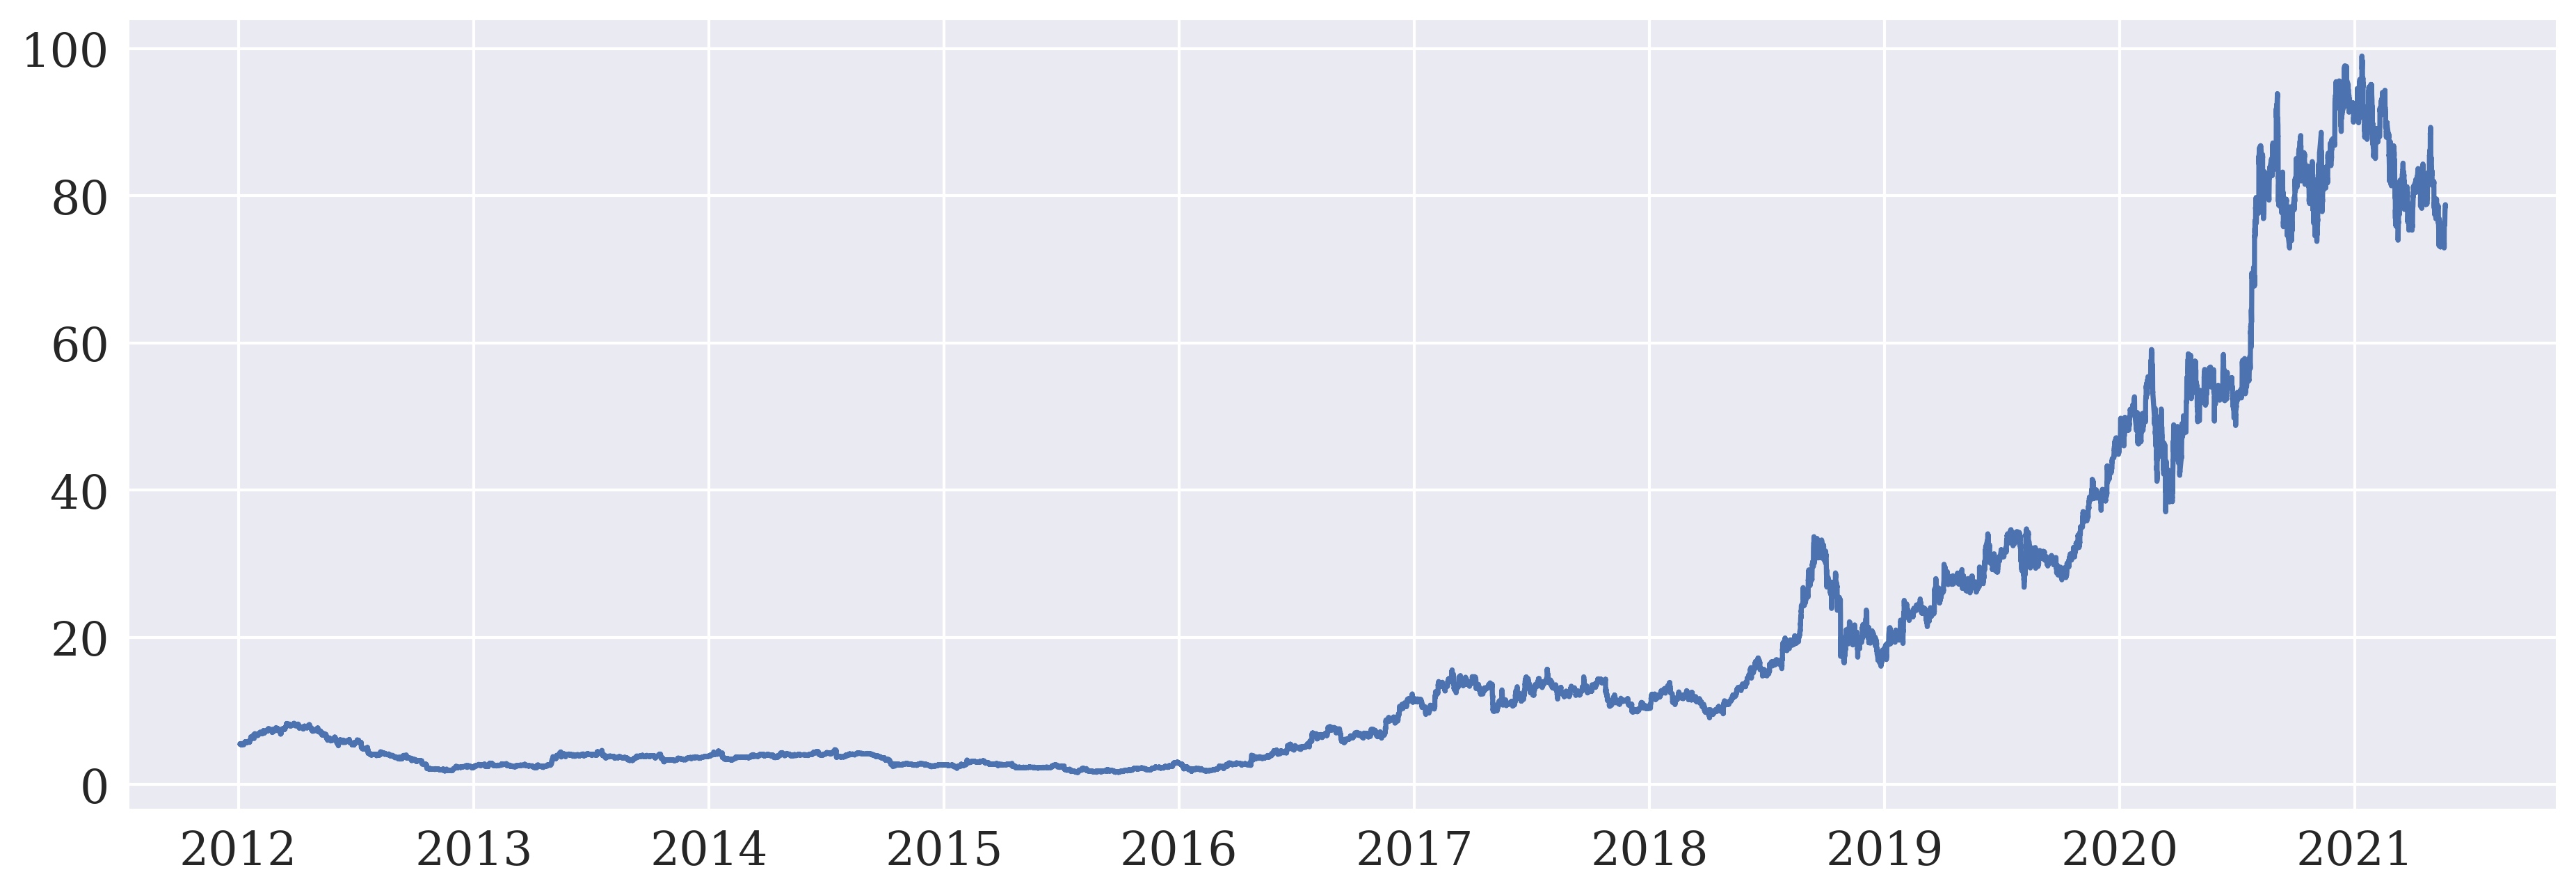

In [4]:
data_stock = get_data_by_hour("AMD")
data_stock

In [5]:
data_stock.loc['2012-06-21 10:00:00']

volume    100.00
vw          6.12
open        6.12
close       6.12
high        6.12
low         6.12
number      1.00
Name: 2012-06-21 10:00:00, dtype: float64

In [6]:
price = data_stock['close']


def get_Daily_Volatility(close,span0=24):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0
df0 = get_Daily_Volatility(price)

#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [3, 2]
#allign the index
prices = price[daily_volatility.index]

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 'price', 'vert_barrier', 'top_barrier', 'bottom_barrier'], index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc[daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', \
        'vert_barrier','top_barrier', 'bottom_barrier']] = \
         days_passed, prices.loc[day], vert_barrier, \
         top_barrier, bottom_barrier
    barriers['out'] = None
    return barriers


barriers = get_3_barriers()

def get_labels():
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
                # assign the initial and final price
                price_initial = barriers.price[start]
                price_final = barriers.price[end]
    # assign the top and bottom barriers
                top_barrier = barriers.top_barrier[i]
                bottom_barrier = barriers.bottom_barrier[i]
    #set the profit taking and stop loss conditons
                condition_pt = (barriers.price[start: end] >= \
                 top_barrier).any()
                condition_sl = (barriers.price[start: end] <= \
                 bottom_barrier).any()
    #assign the labels
                if condition_pt: 
                    barriers['out'][i] = 1
                elif condition_sl: 
                    barriers['out'][i] = -1    
                else: 
                    barriers['out'][i] = 0
    return

get_labels()

In [7]:
barriers.out.value_counts()

 0    13498
-1    11274
 1     8311
Name: out, dtype: int64

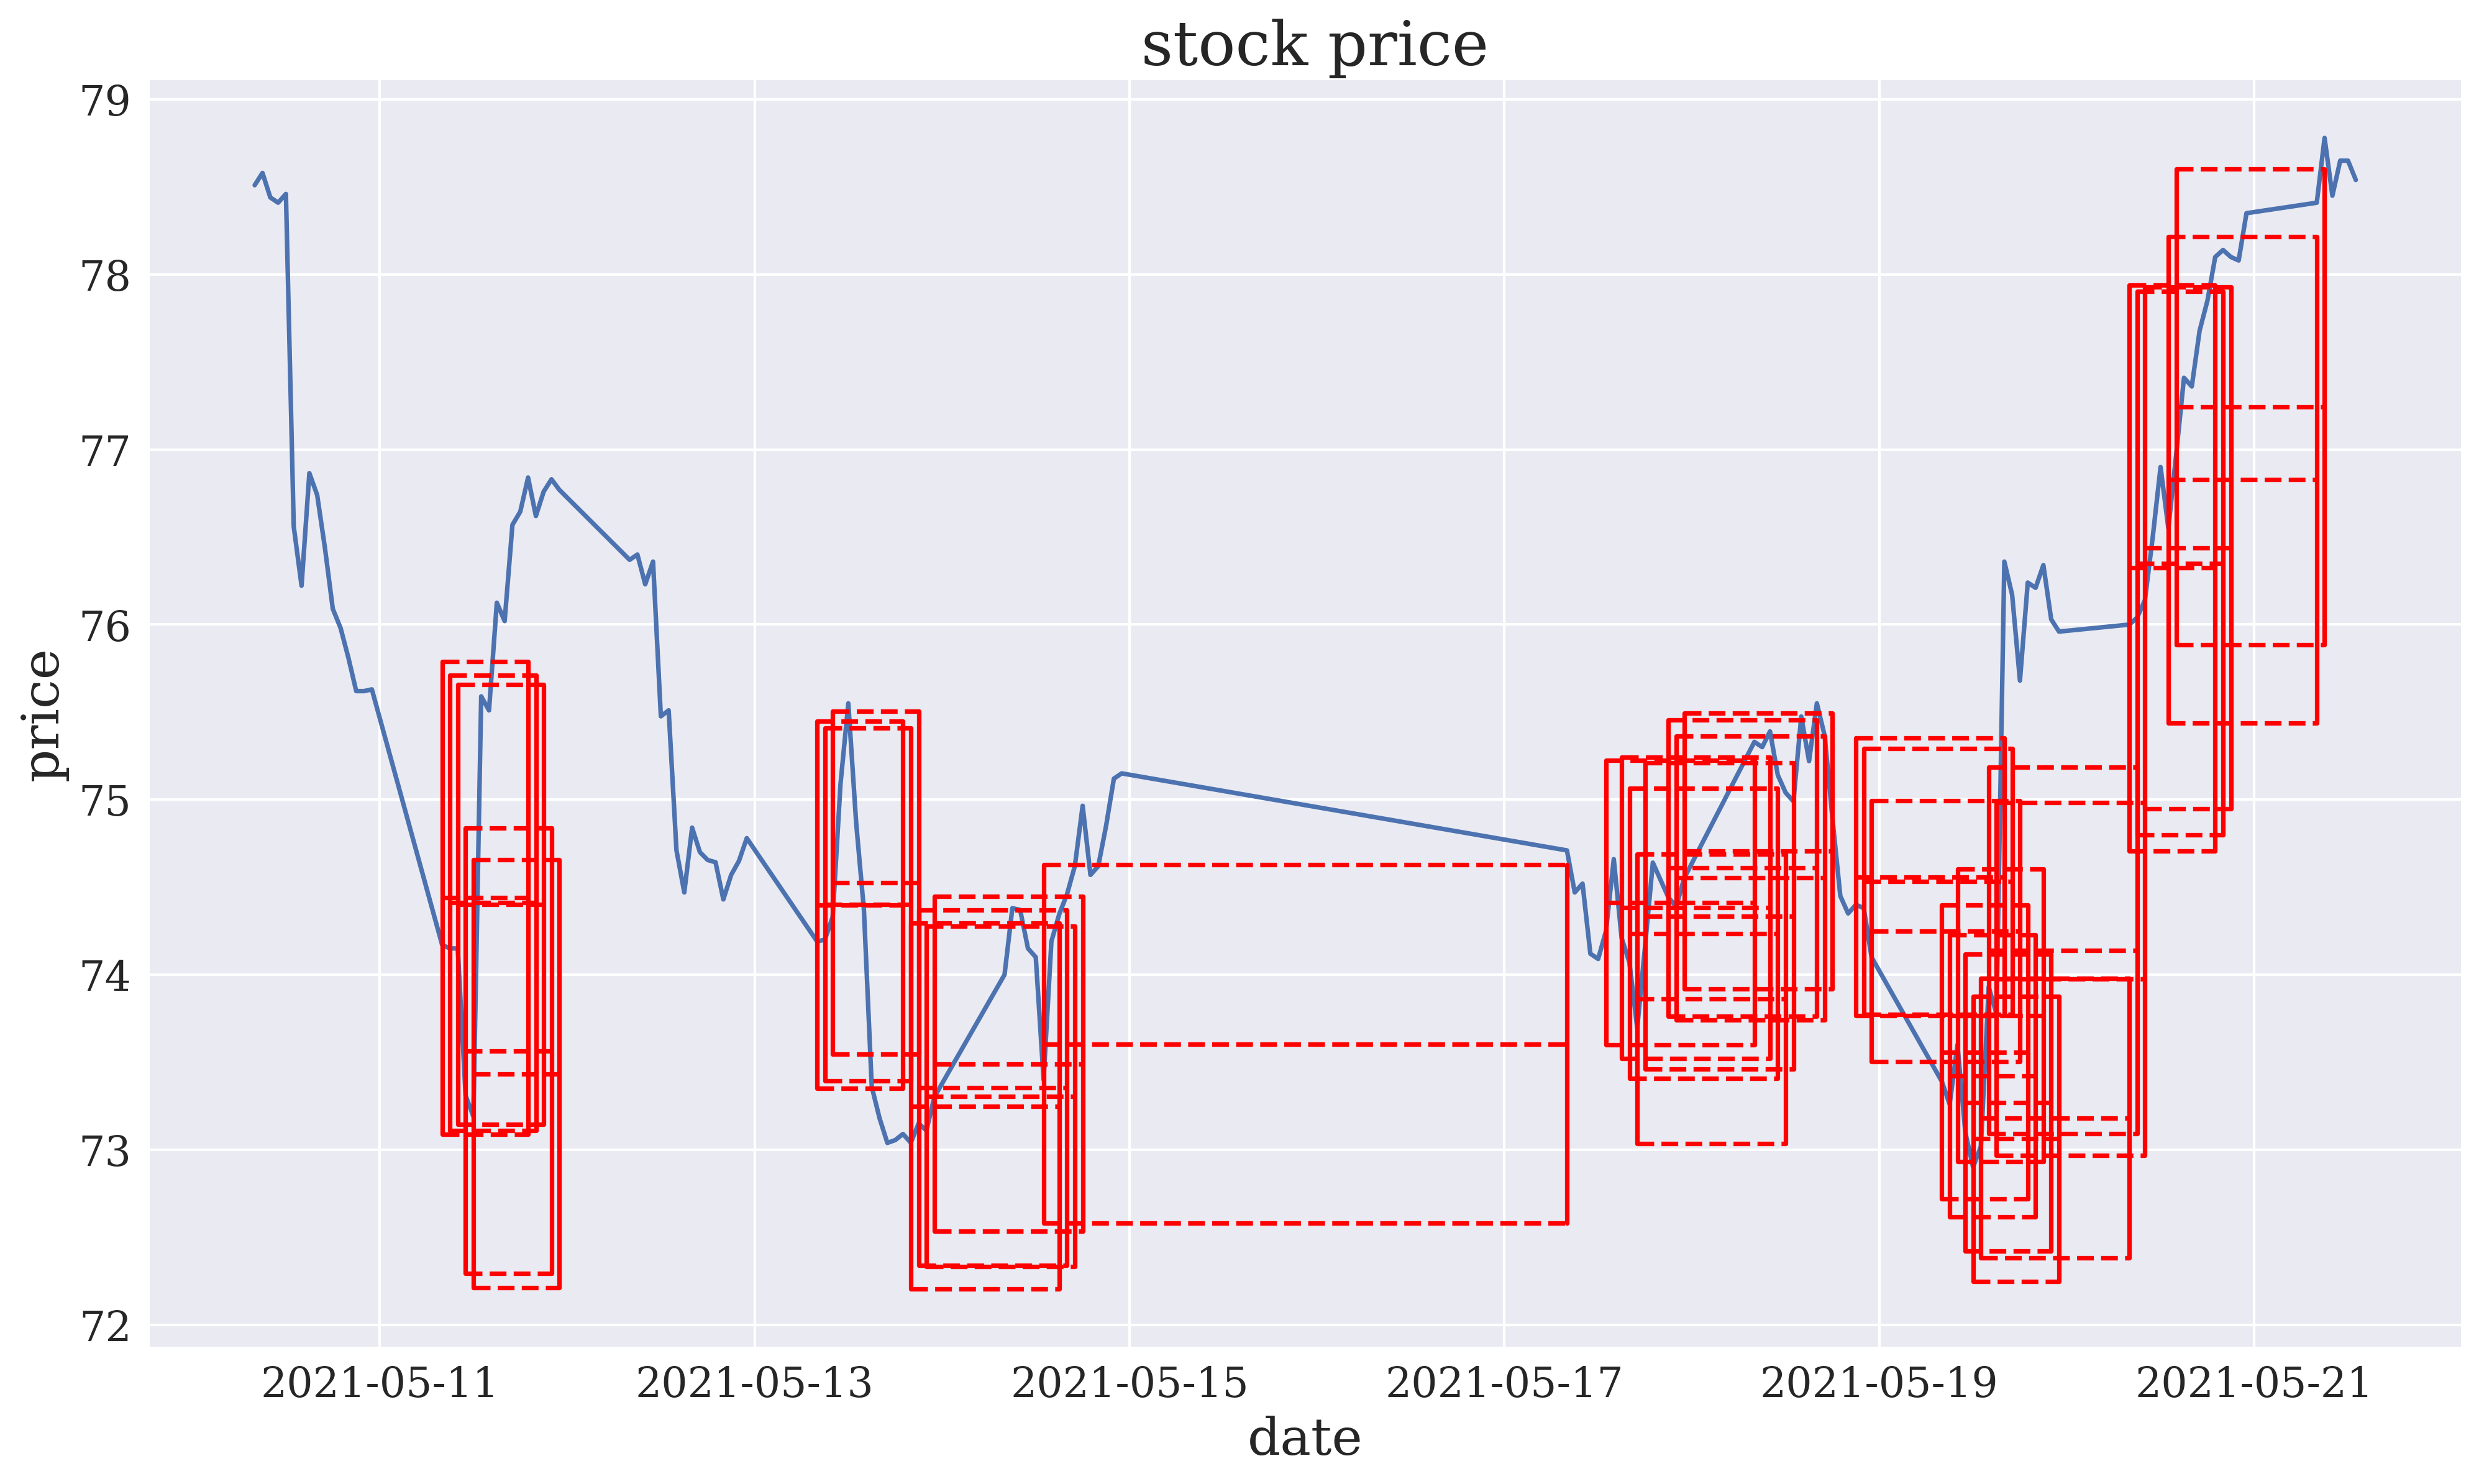

In [8]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-150:])
for i in barriers.index[-155:]:
    barrier = barriers.loc[i]
    start = i
    end = barrier.vert_barrier
    if not pd.isnull(end) and barrier.out == 1:
        upper_barrier = barrier.top_barrier
        lower_barrier = barrier.bottom_barrier
        ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
        ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
        ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
        ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
        ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [9]:
def create_HLCV(i): 
    df = pd.DataFrame(index=data_stock.index)
    df[f'high_{i}'] = data_stock.high.rolling(i).max()
    df[f'low_{i}'] = data_stock.low.rolling(i).min()
    df[f'close_{i}'] = data_stock.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    df[f'volume_{i}'] = data_stock.volume.rolling(i).sum()
    
    return df

In [10]:
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}']
    low = df[f'low_{i}']
    close = df[f'close_{i}']
    volume = df[f'volume_{i}']
    features = pd.DataFrame(index=data_stock.index)
    features[f'volume_{i}'] = volume
    features[f'price_spread_{i}'] = high - low
    features[f'close_loc_{i}'] = (high - close) / (high - low)
    features[f'close_change_{i}'] = close.diff()
    
    return features

In [11]:
def create_bunch_of_features():
    days = [1,2,3,5,6,7,8,9,10,20,40,60]
    bunch_of_features = pd.DataFrame(index=data_stock.index)
    for day in days:
        f = create_features(day)
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33096 entries, 2012-01-03 12:00:00 to 2021-05-21 13:00:00
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   volume_1         33096 non-null  float64
 1   price_spread_1   33096 non-null  float64
 2   close_loc_1      31067 non-null  float64
 3   close_change_1   33095 non-null  float64
 4   volume_2         33095 non-null  float64
 5   price_spread_2   33095 non-null  float64
 6   close_loc_2      32846 non-null  float64
 7   close_change_2   33094 non-null  float64
 8   volume_3         33094 non-null  float64
 9   price_spread_3   33094 non-null  float64
 10  close_loc_3      33060 non-null  float64
 11  close_change_3   33093 non-null  float64
 12  volume_5         33092 non-null  float64
 13  price_spread_5   33092 non-null  float64
 14  close_loc_5      33092 non-null  float64
 15  close_change_5   33091 non-null  float64
 16  volume_6         33091 

In [12]:
dropna_barriers = barriers.dropna()
data = bunch_of_features[60:-13].assign(out=dropna_barriers[58:-2].out)
data.dropna(inplace=True)
out = data.out
out=out.astype('int')
data.drop('out', axis=1, inplace=True)
data

,volume_1,price_spread_1,close_loc_1,close_change_1,volume_2,price_spread_2,close_loc_2,close_change_2,volume_3,price_spread_3,...,close_loc_20,close_change_20,volume_40,price_spread_40,close_loc_40,close_change_40,volume_60,price_spread_60,close_loc_60,close_change_60
2012-01-10 13:00:00,15004.0,0.0400,0.250000,0.0200,15304.0,0.0400,0.250000,0.0200,16742.0,0.1100,...,0.033333,0.0200,35540898.0,0.3300,0.030303,0.0200,55633821.0,0.3300,0.030303,0.0200
2012-01-10 14:00:00,1393823.0,0.1000,0.450000,0.0250,1408827.0,0.1000,0.450000,0.0250,1409127.0,0.1000,...,0.125000,0.0250,36908307.0,0.3900,0.115385,0.0250,57002693.0,0.3900,0.115385,0.0250
2012-01-10 15:00:00,1349910.0,0.0500,0.800000,-0.0050,2743733.0,0.1000,0.500000,-0.0050,2758737.0,0.1000,...,0.138889,-0.0050,38253617.0,0.3900,0.128205,-0.0050,56993464.0,0.3900,0.128205,-0.0050
2012-01-10 16:00:00,2673112.0,0.0800,0.093750,0.0225,4023022.0,0.0900,0.194444,0.0225,5416845.0,0.1000,...,0.076389,0.0225,40925629.0,0.3900,0.070513,0.0225,56843680.0,0.3900,0.070513,0.0225
2012-01-10 17:00:00,1272293.0,0.0400,0.000000,0.0275,3945405.0,0.1000,0.000000,0.0275,5295315.0,0.1000,...,0.000000,0.0275,42179422.0,0.3900,0.000000,0.0275,56936119.0,0.3900,0.000000,0.0275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20 12:00:00,278549.0,0.7889,0.063379,0.4000,370865.0,0.8300,0.060241,0.4000,376104.0,0.9900,...,0.016317,0.4000,104722548.0,4.2900,0.016317,0.4000,156930255.0,4.2900,0.016317,0.4000
2021-05-20 13:00:00,9734382.0,1.1199,0.732119,-0.3500,10012931.0,1.2088,0.678276,-0.3500,10105247.0,1.2499,...,0.174822,-0.3500,114399889.0,4.6899,0.174822,-0.3500,164264743.0,4.6899,0.174822,-0.3500
2021-05-20 14:00:00,8867204.0,0.8500,0.163882,0.4207,18601586.0,1.1199,0.356460,0.4207,18880135.0,1.2088,...,0.085119,0.4207,123254642.0,4.6899,0.085119,0.4207,169649620.0,4.6899,0.085119,0.4207
2021-05-20 15:00:00,6396427.0,0.5998,0.149883,0.4393,15263631.0,1.2399,0.072506,0.4393,24998013.0,1.2499,...,0.018652,0.4393,129611875.0,4.8199,0.018652,0.4393,170360134.0,4.8199,0.018652,0.4393


In [13]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=20)

model.fit(data, out)

Learning rate set to 0.5
0:	learn: 1.0655522	total: 85.3ms	remaining: 1.62s
1:	learn: 1.0534595	total: 104ms	remaining: 940ms
2:	learn: 1.0464153	total: 127ms	remaining: 719ms
3:	learn: 1.0413695	total: 146ms	remaining: 586ms
4:	learn: 1.0385908	total: 165ms	remaining: 496ms
5:	learn: 1.0352561	total: 184ms	remaining: 430ms
6:	learn: 1.0324998	total: 203ms	remaining: 377ms
7:	learn: 1.0297717	total: 223ms	remaining: 334ms
8:	learn: 1.0278741	total: 242ms	remaining: 296ms
9:	learn: 1.0264044	total: 261ms	remaining: 261ms
10:	learn: 1.0232428	total: 281ms	remaining: 230ms
11:	learn: 1.0212784	total: 301ms	remaining: 200ms
12:	learn: 1.0193812	total: 320ms	remaining: 173ms
13:	learn: 1.0177461	total: 338ms	remaining: 145ms
14:	learn: 1.0160671	total: 356ms	remaining: 119ms
15:	learn: 1.0140374	total: 375ms	remaining: 93.9ms
16:	learn: 1.0113198	total: 395ms	remaining: 69.6ms
17:	learn: 1.0090640	total: 415ms	remaining: 46.1ms
18:	learn: 1.0062350	total: 437ms	remaining: 23ms
19:	learn: 1.

In [14]:
predictions = model.predict(bunch_of_features[-30:])

In [15]:
predictions

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [-1],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 0]])

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion="entropy")
clf.fit(data, out)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=1000)

In [17]:
predictions2 = clf.predict(bunch_of_features.iloc[-30:])

In [18]:
predictions2

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  1,  1,  0,  0,
        0,  0,  0,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1])

In [19]:
predictions2[-10]

0

In [20]:
new_barriers = barriers[-30:].assign(predictions_out1=predictions[:,0])
new_barriers = new_barriers.assign(predictions_out2=predictions2)
new_barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out,predictions_out1,predictions_out2
2021-05-19 16:00:00,33065,76.36,2021-05-20 11:00:00,78.905441,74.66304,0,0,0
2021-05-19 17:00:00,33066,76.17,2021-05-20 12:00:00,78.625881,74.532746,0,0,0
2021-05-19 18:00:00,33067,75.68,2021-05-20 13:00:00,78.081336,74.079109,0,0,0
2021-05-19 19:00:00,33068,76.24,2021-05-20 14:00:00,78.591035,74.672643,0,0,0
2021-05-19 20:00:00,33069,76.21,2021-05-20 15:00:00,78.468833,74.704111,0,0,0
2021-05-19 21:00:00,33070,76.34,2021-05-20 16:00:00,78.510293,74.893138,0,0,0
2021-05-19 22:00:00,33071,76.03,2021-05-20 17:00:00,78.135144,74.62657,0,0,0
2021-05-19 23:00:00,33072,75.96,2021-05-20 18:00:00,77.981999,74.612001,0,0,0
2021-05-20 08:00:00,33073,76.0,2021-05-20 19:00:00,77.94077,74.706153,1,0,1
2021-05-20 09:00:00,33074,76.04,2021-05-20 20:00:00,77.902781,74.798146,1,0,1


In [21]:
new_barriers.to_excel('/Users/germanignatovich/Desktop/work/Диплом/%s.xlsx' % new_barriers.index[-1].strftime("%Y-%m-%d_%H:%M:%S"))

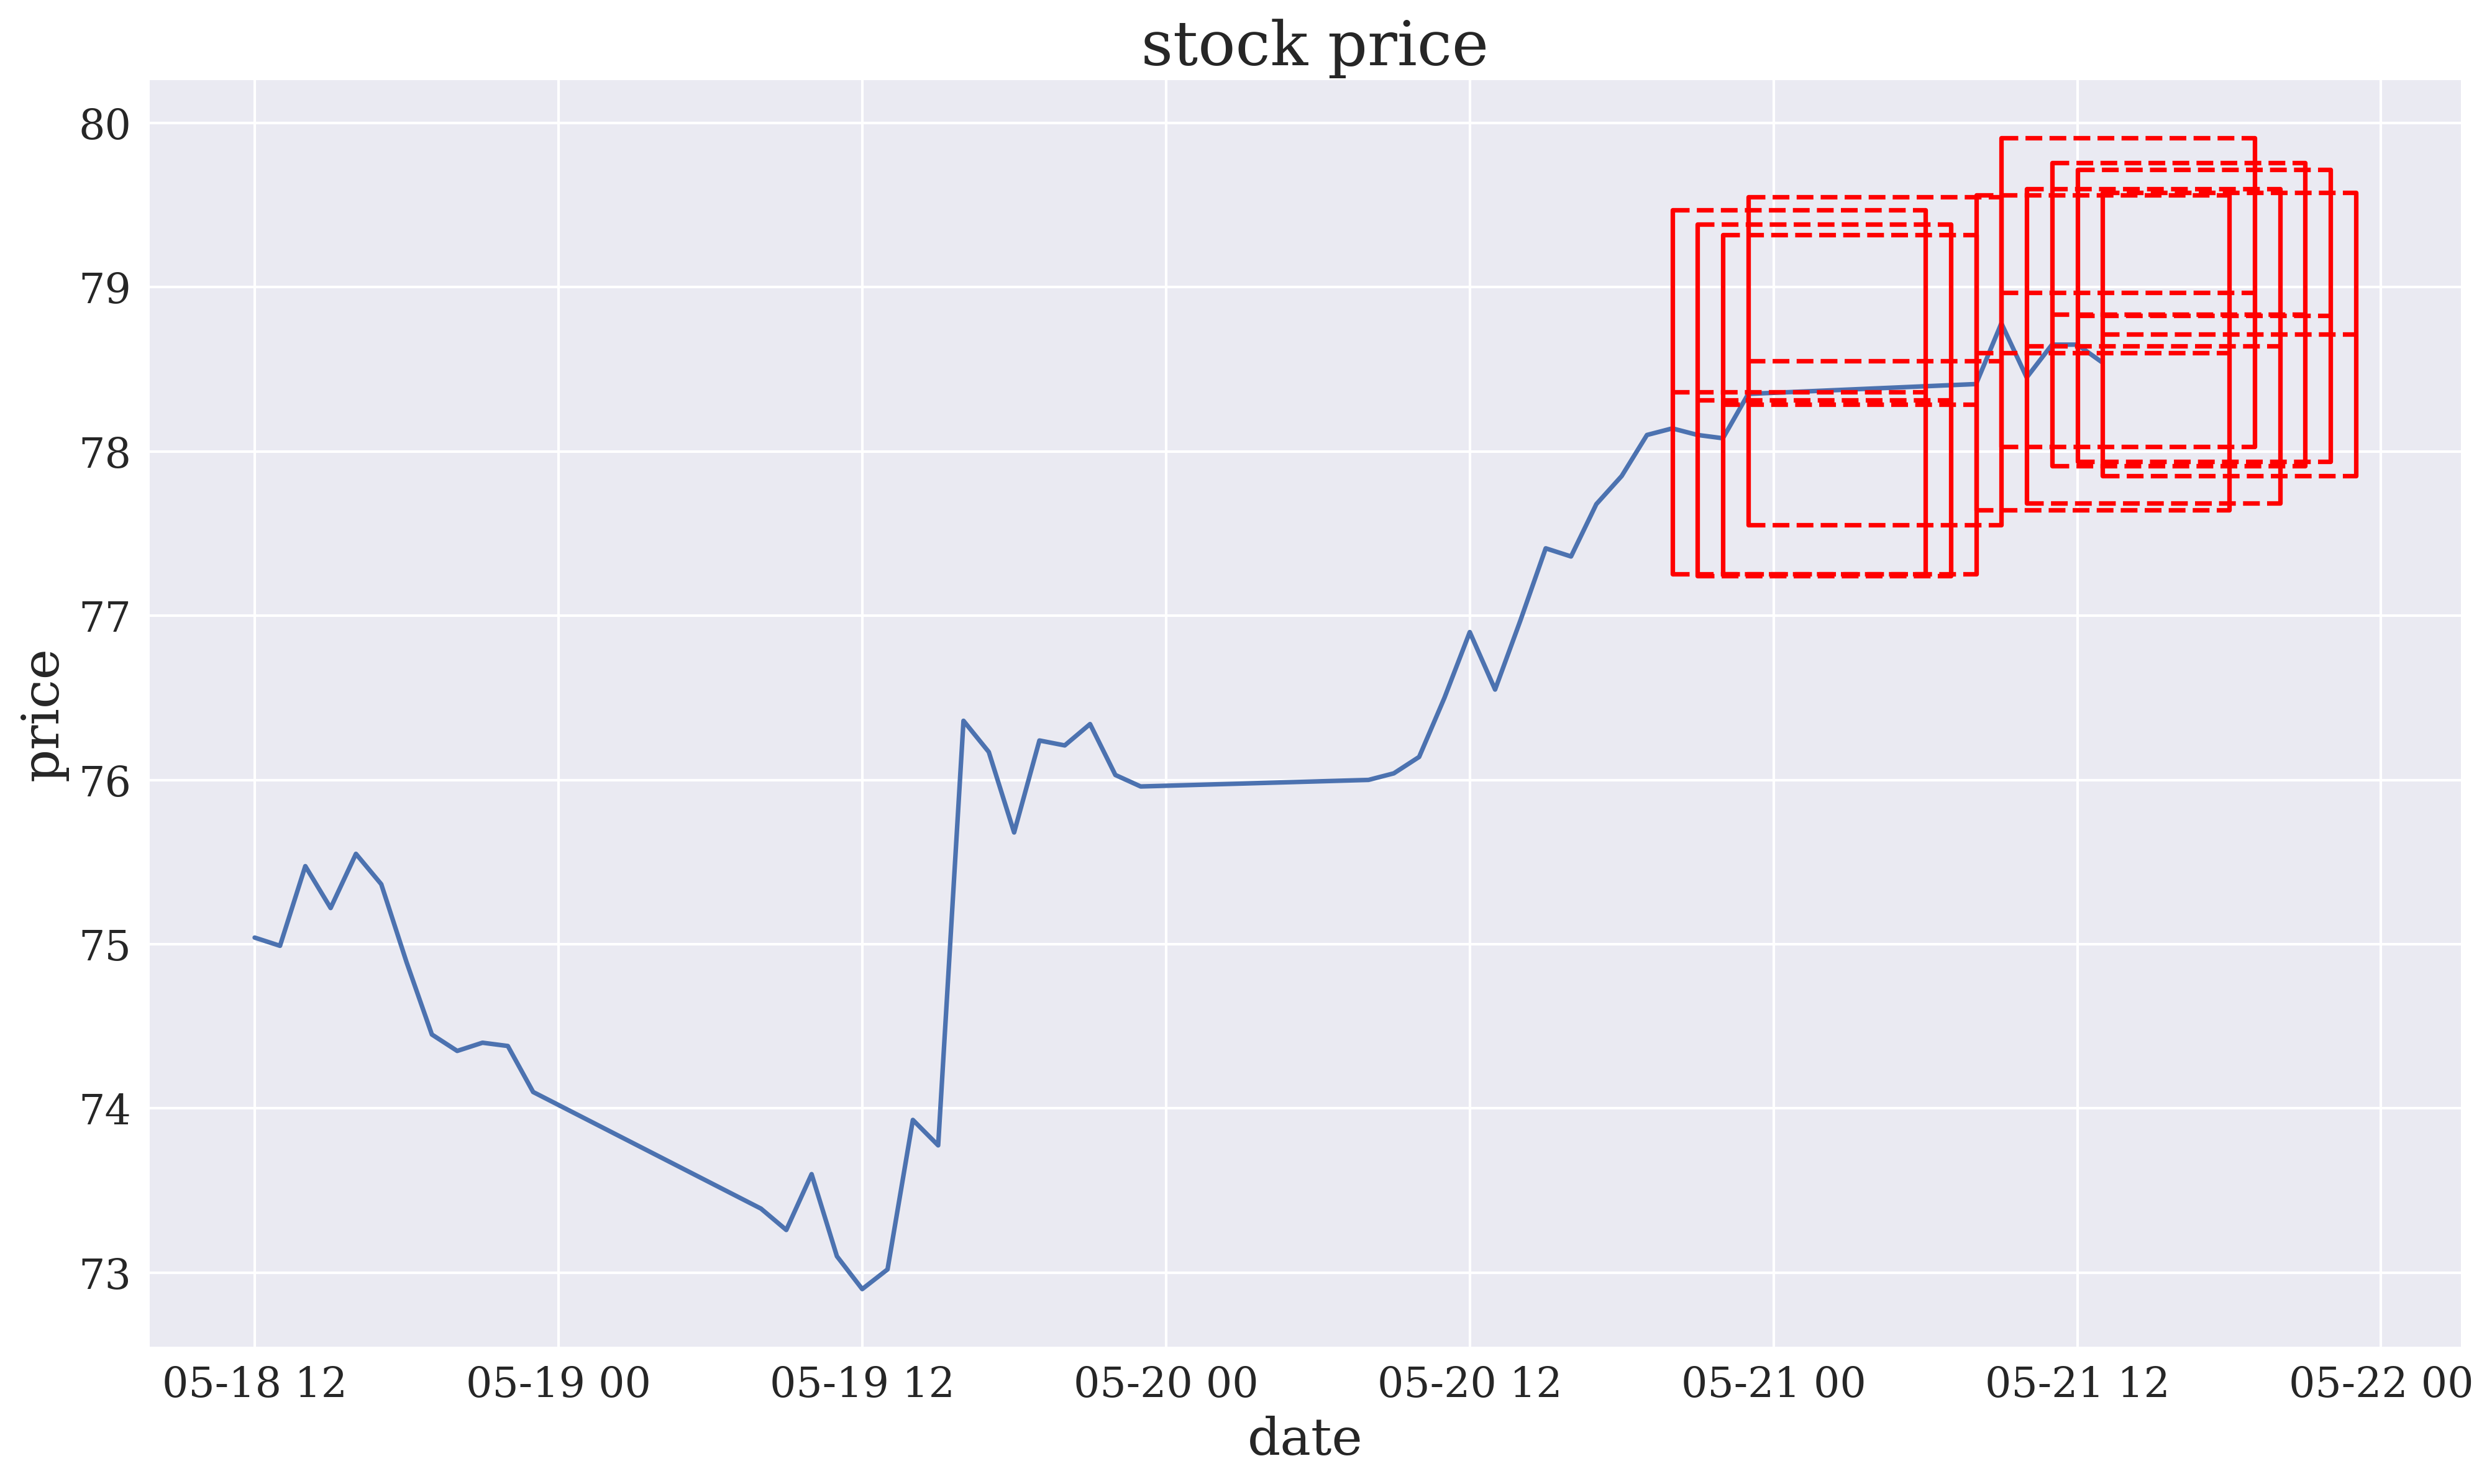

In [22]:
fig,ax = plt.subplots()
ax.set(title=' stock price', xlabel='date', ylabel='price')
ax.plot(barriers.price[-50:])
for i in barriers.index[-10:]:
    barrier = barriers.loc[i]
    start = i
    end = (datetime.strptime(i.strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S') + timedelta(hours = 10))
    upper_barrier = barrier.top_barrier
    lower_barrier = barrier.bottom_barrier
    ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
    ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
    ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'r--');
    ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
    ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');